Loading models...
Extracting Person A: 20241127_091619.jpg
Extracting Person B: DSC08983.jpg

------------------------------------------------
SIMILARITY SCORE: 0.6641
CONCLUSION: SAME PERSON
------------------------------------------------


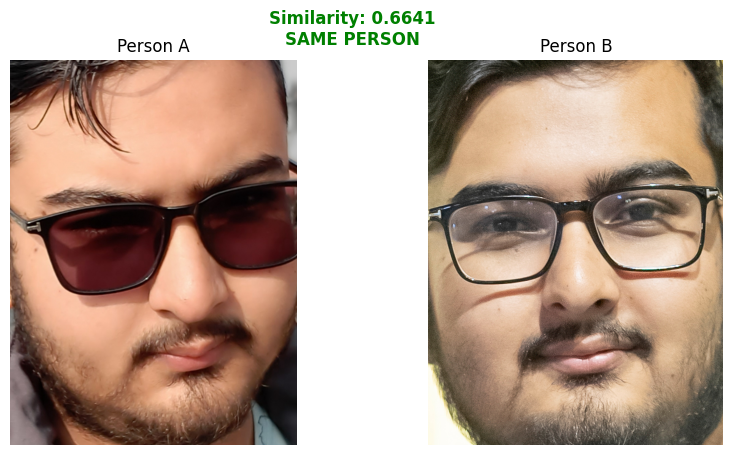

In [2]:
import cv2
import numpy as np
import onnxruntime
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ==========================================
# 1. SETUP PATHS
# ==========================================
# Update these paths to point to your actual images
PERSON_A_IMAGE = "/home/sandeshprasai/Projects/Final_Semester_Project/AI_Attendance_System/ai-ml-model/DataSets/SandeshPrasai/20241127_091619.jpg" 
PERSON_B_IMAGE = "/home/sandeshprasai/Projects/Final_Semester_Project/AI_Attendance_System/ai-ml-model/DataSets/SandeshPrasai/DSC08983.jpg"

# Model Paths
BASE_DIR = "." 
YOLO_PATH = "../../src/models/Final_YoloV8n_RestNetModelForRecognitionPipeline/Detector/best.pt"
ARCFACE_PATH = "../../src/models/Final_YoloV8n_RestNetModelForRecognitionPipeline/embedding/w600k_r50.onnx"

# ==========================================
# 2. MODEL CLASSES
# ==========================================
class ArcFaceEmbedder:
    def __init__(self, model_path):
        providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
        try:
            self.session = onnxruntime.InferenceSession(model_path, providers=providers)
        except:
            self.session = onnxruntime.InferenceSession(model_path, providers=['CPUExecutionProvider'])
        self.input_name = self.session.get_inputs()[0].name
        self.output_name = self.session.get_outputs()[0].name

    def get_embedding(self, face_img):
        # Preprocess: Resize to 112x112, RGB, Normalize
        resized = cv2.resize(face_img, (112, 112))
        resized_rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        input_blob = (resized_rgb.astype(np.float32) - 127.5) / 127.5
        input_blob = np.transpose(input_blob, (2, 0, 1))
        input_blob = np.expand_dims(input_blob, axis=0)
        
        # Inference
        embedding = self.session.run([self.output_name], {self.input_name: input_blob})[0]
        embedding = embedding.flatten()
        
        # Normalize (Crucial for comparison)
        norm = np.linalg.norm(embedding)
        if norm > 0:
            embedding = embedding / norm
        return embedding

def get_face(image_path, yolo_model):
    """Detects and returns the largest face crop"""
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return None

    frame = cv2.imread(image_path)
    results = yolo_model(frame, verbose=False)
    
    max_area = 0
    best_crop = None

    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            h, w = frame.shape[:2]
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            
            area = (x2 - x1) * (y2 - y1)
            if area > max_area:
                max_area = area
                best_crop = frame[y1:y2, x1:x2]
                
    return best_crop

# ==========================================
# 3. COMPARISON LOGIC
# ==========================================
def compare_identities(path_a, path_b):
    # Load Models
    print("Loading models...")
    yolo = YOLO(YOLO_PATH)
    embedder = ArcFaceEmbedder(ARCFACE_PATH)
    
    print(f"Extracting Person A: {os.path.basename(path_a)}")
    face_a = get_face(path_a, yolo)
    
    print(f"Extracting Person B: {os.path.basename(path_b)}")
    face_b = get_face(path_b, yolo)
    
    if face_a is None or face_b is None:
        print("❌ Error: Could not detect a face in one of the images.")
        return

    # Get Embeddings
    emb_a = embedder.get_embedding(face_a)
    emb_b = embedder.get_embedding(face_b)
    
    # Calculate Similarity (Dot Product)
    score = np.dot(emb_a, emb_b)
    
    # Interpretation
    # Thresholds: >0.5 usually same person, <0.3 usually different
    color = "red" if score < 0.4 else "green"
    result_text = "DIFFERENT PEOPLE" if score < 0.4 else "SAME PERSON"
    
    print(f"\n------------------------------------------------")
    print(f"SIMILARITY SCORE: {score:.4f}")
    print(f"CONCLUSION: {result_text}")
    print(f"------------------------------------------------")

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(cv2.cvtColor(face_a, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Person A")
    ax[0].axis("off")
    
    ax[1].imshow(cv2.cvtColor(face_b, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Person B")
    ax[1].axis("off")
    
    plt.suptitle(f"Similarity: {score:.4f}\n{result_text}", color=color, weight='bold')
    plt.show()

# ==========================================
# 4. RUN TEST
# ==========================================
# Create dummy files if you don't have them yet, just to prevent errors
if not os.path.exists(PERSON_A_IMAGE) or not os.path.exists(PERSON_B_IMAGE):
    print("⚠️ Please set PERSON_A_IMAGE and PERSON_B_IMAGE paths correctly.")
else:
    compare_identities(PERSON_A_IMAGE, PERSON_B_IMAGE)

In [ ]:
import cv2
import numpy as np
import onnxruntime as ort

# -------- Paths --------
LANDMARK_MODEL = "/home/sandeshprasai/Projects/Final_Semester_Project/AI_Attendance_System/ai-ml-model/src/models/Final_YoloV8n_RestNetModelForRecognitionPipeline/landmark/2d106det.onnx"

# -------- Load model --------
sess = ort.InferenceSession(LANDMARK_MODEL, providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
input_shape = sess.get_inputs()[0].shape
input_height = input_shape[2]  # Usually 192
input_width = input_shape[3]   # Usually 192

# -------- Config --------
BOX_EXPAND_RATIO = 1.3  # Reduced from 1.5 for better fit

def preprocess(img):
    h, w, _ = img.shape
    # Scale to fit in 192x192 while keeping aspect ratio
    scale = min(input_height / h, input_width / w)
    nh, nw = int(h * scale), int(w * scale)
    resized = cv2.resize(img, (nw, nh))
    
    # Pad to 192x192
    pad_h = input_height - nh
    pad_w = input_width - nw
    top, bottom = pad_h // 2, pad_h - pad_h // 2
    left, right = pad_w // 2, pad_w - pad_w // 2
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    
    # Convert BGR -> RGB
    padded = cv2.cvtColor(padded, cv2.COLOR_BGR2RGB)
    
    # Normalize: (x - 127.5) / 128.0
    blob = (padded.astype(np.float32) - 127.5) / 128.0
    
    blob = np.transpose(blob, (2, 0, 1))
    return blob[np.newaxis, :], scale, top, left, nh, nw

# -------- Start camera --------
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

if not cap.isOpened():
    print("Error: Could not open camera")
    exit()

print("Press 'q' to quit")

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        # Draw original Haar detection (Blue)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
        # Expand the box (Loose Crop)
        cx, cy = x + w // 2, y + h // 2
        new_w = int(w * BOX_EXPAND_RATIO)
        new_h = int(h * BOX_EXPAND_RATIO)
        new_x = max(0, cx - new_w // 2)
        new_y = max(0, cy - new_h // 2)
        new_x = min(frame.shape[1] - new_w, new_x)
        new_y = min(frame.shape[0] - new_h, new_y)
        new_w = min(frame.shape[1] - new_x, new_w)
        new_h = min(frame.shape[0] - new_y, new_h)

        # Crop the expanded face
        face_roi = frame[new_y:new_y+new_h, new_x:new_x+new_w]
        
        if face_roi.size == 0: 
            continue

        # Preprocess
        blob, scale, top_pad, left_pad, scaled_h, scaled_w = preprocess(face_roi)
        
        # Inference
        outputs = sess.run(None, {input_name: blob})[0]
        landmarks = outputs.reshape(-1, 2)
        
        # FIXED: Proper coordinate transformation
        # Step 1: Denormalize from model output space (usually [-1, 1] or [0, 1])
        # Try this first (assuming output is in [-1, 1] range):
        landmarks_denorm = (landmarks + 1.0) * 0.5  # Convert [-1,1] to [0,1]
        
        # Step 2: Map to padded image coordinates [0, 192]
        landmarks_padded = landmarks_denorm * input_width  # Now in [0, 192]
        
        # Step 3: Remove padding offset
        landmarks_scaled = landmarks_padded.copy()
        landmarks_scaled[:, 0] -= left_pad
        landmarks_scaled[:, 1] -= top_pad
        
        # Step 4: Scale back to ROI size
        landmarks_roi = landmarks_scaled / scale
        
        # Step 5: Translate to frame coordinates
        landmarks_frame = landmarks_roi.copy()
        landmarks_frame[:, 0] += new_x
        landmarks_frame[:, 1] += new_y
        
        # Draw expanded box (Green)
        cv2.rectangle(frame, (new_x, new_y), (new_x + new_w, new_y + new_h), (0, 255, 0), 1)
        
        # Draw landmarks (Bright Green)
        for (lx, ly) in landmarks_frame.astype(int):
            cv2.circle(frame, (lx, ly), 2, (0, 255, 0), -1)
        
        # Display mouse position for debugging
        cv2.putText(frame, f"ROI: {new_w}x{new_h}", (new_x, new_y - 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
    cv2.imshow('Face Landmarks Detection', frame)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()